### Importing Libraries

In [1]:
import random
from pathlib import Path
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sklearn
import sys
from torchvision import transforms
from torchvision.transforms import InterpolationMode

# Familiarization

## AI Images
First we will extract the extensions of the files so that we know what files we are dealing with. We will find all unique file extensions and provide some general statistics about them

In [2]:
from collections import Counter

# Find all unique file extensions in the given directory
def get_extension_counts(path):
    all_files = list(path.glob("*"))
    extensions = [file.suffix.lower() for file in all_files if file.is_file()]
    return Counter(extensions)

In [3]:
ai_data_path = Path("../data/AiArtData/AiArtData/")

extension_counts = get_extension_counts(ai_data_path)

print("AI Images - File extensions found:")
for ext, count in sorted(extension_counts.items()):
    print(f"  {ext}: {count} {count == 1 and 'file' or 'files'}")

print(f"Total files: {sum(extension_counts.values())}")
print(f"Unique extensions: {list(extension_counts.keys())}")


AI Images - File extensions found:
  .jpeg: 36 files
  .jpg: 385 files
  .png: 115 files
  .webp: 3 files
Total files: 539
Unique extensions: ['.png', '.jpg', '.jpeg', '.webp']


We can see that most of the files are .jpg and .png, but there are actually 3 .webp files that we could have missed if we had not gone through this step

We will now display 7 random AI images to familiarize ourselves with how AI images are supposed to look like. Futhermore we will also display their sizes, in order to see if they are the same size.

In [4]:
## Function to display random images in a grid from the given list of images
def display_random_images(image_list, num_images=4):
    rows = num_images//3 if num_images % 3 == 0 else (num_images // 3) + 1 # '//' floors the division 
    # Scale figsize based on number of rows and columns (3 columns)
    figsize = (15, rows * 4)  # 15 width for 3 columns, 4 inches per row
    fig, axes = plt.subplots(rows, 3, figsize=figsize)
    axes = axes.flatten()  # Flatten the 2D array to 1D so we can index axes correctly
    
    for idx, img_path in enumerate(random.sample(image_list, min(num_images, len(image_list)))):
        # Load the image
        ai_image = Image.open(img_path)
        
        # Display the image
        axes[idx].imshow(ai_image)
        axes[idx].axis('off')  # Remove axes for cleaner look
        axes[idx].set_title(f"{img_path.name}\nSize: {ai_image.size}", fontsize=12)
    
    
    # Hide any unused subplots
    for j in range(num_images, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

539 AI-generated images found.



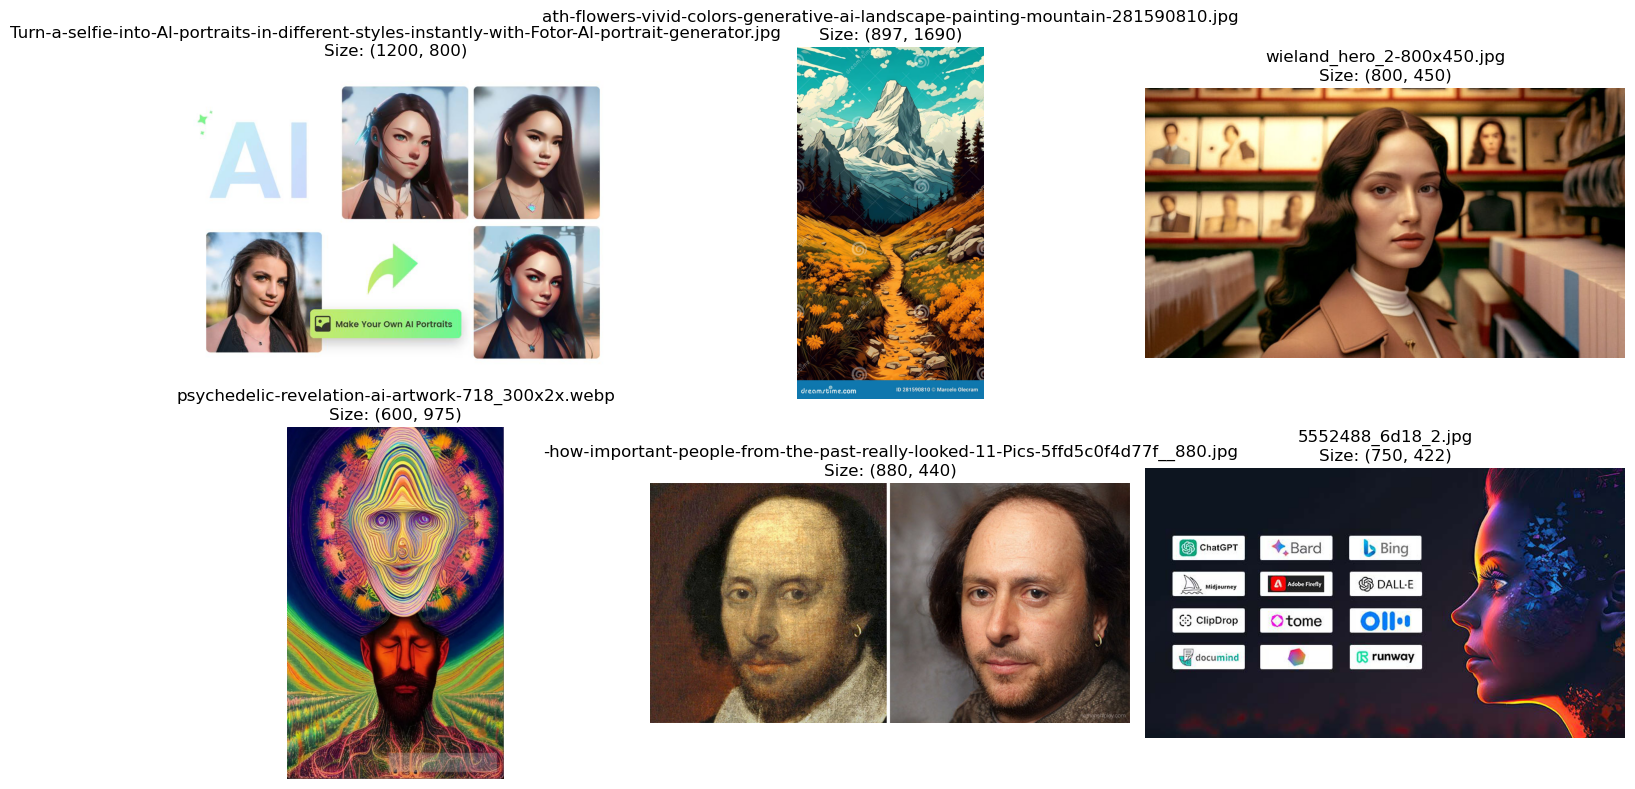

In [5]:
# Get all image files using glob with multiple extensions
ai_images_data = []
for ext in ['*.jpg', '*.jpeg', '*.png', '*.webp']:
    ai_images_data.extend(ai_data_path.glob(ext))

print(f"{len(ai_images_data)} AI-generated images found.\n")

if ai_images_data:
    # Display 6 random images in a grid
    display_random_images(ai_images_data, 6)
else:
    print("No images found in the directory")

It is important to note that images are of different size, so we need to take that into consideration during pre-processing

## Real Images
We will now do the same analysis for the real images.

In [6]:
real_data_path = Path("../data/RealArt/RealArt/")

extension_counts = get_extension_counts(real_data_path)

print("Real Images - File extensions found:")
for ext, count in sorted(extension_counts.items()):
    print(f"  {ext}: {count} {count == 1 and 'file' or 'files'}")

print(f"Total files: {sum(extension_counts.values())}")
print(f"Unique extensions: {list(extension_counts.keys())}")

Real Images - File extensions found:
  : 1 file
  .gif: 1 file
  .jpeg: 21 files
  .jpg: 378 files
  .png: 35 files
Total files: 436
Unique extensions: ['.png', '.jpg', '.jpeg', '', '.gif']


We can see that glob has captured 1 file with its extension being an empty string. We will find the file and display it in order to see if its an image and if its is, we will add it to our images.

1


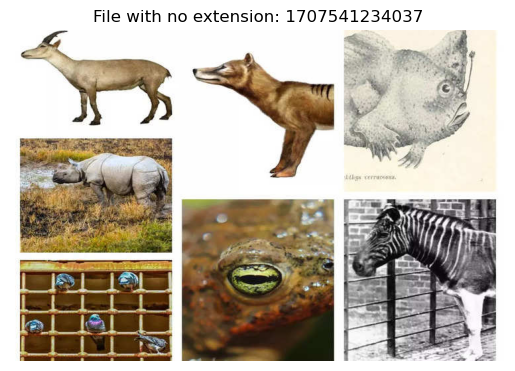

In [7]:
no_ext_files = [f for f in real_data_path.glob("*") if f.is_file() and f.suffix == ""]
print(len(no_ext_files))
for file in no_ext_files:
    img = Image.open(file)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"File with no extension: {file.name}")
    plt.show()

We can see that its clearly an image so we can safely add it to our set of real images

435 Real images found.



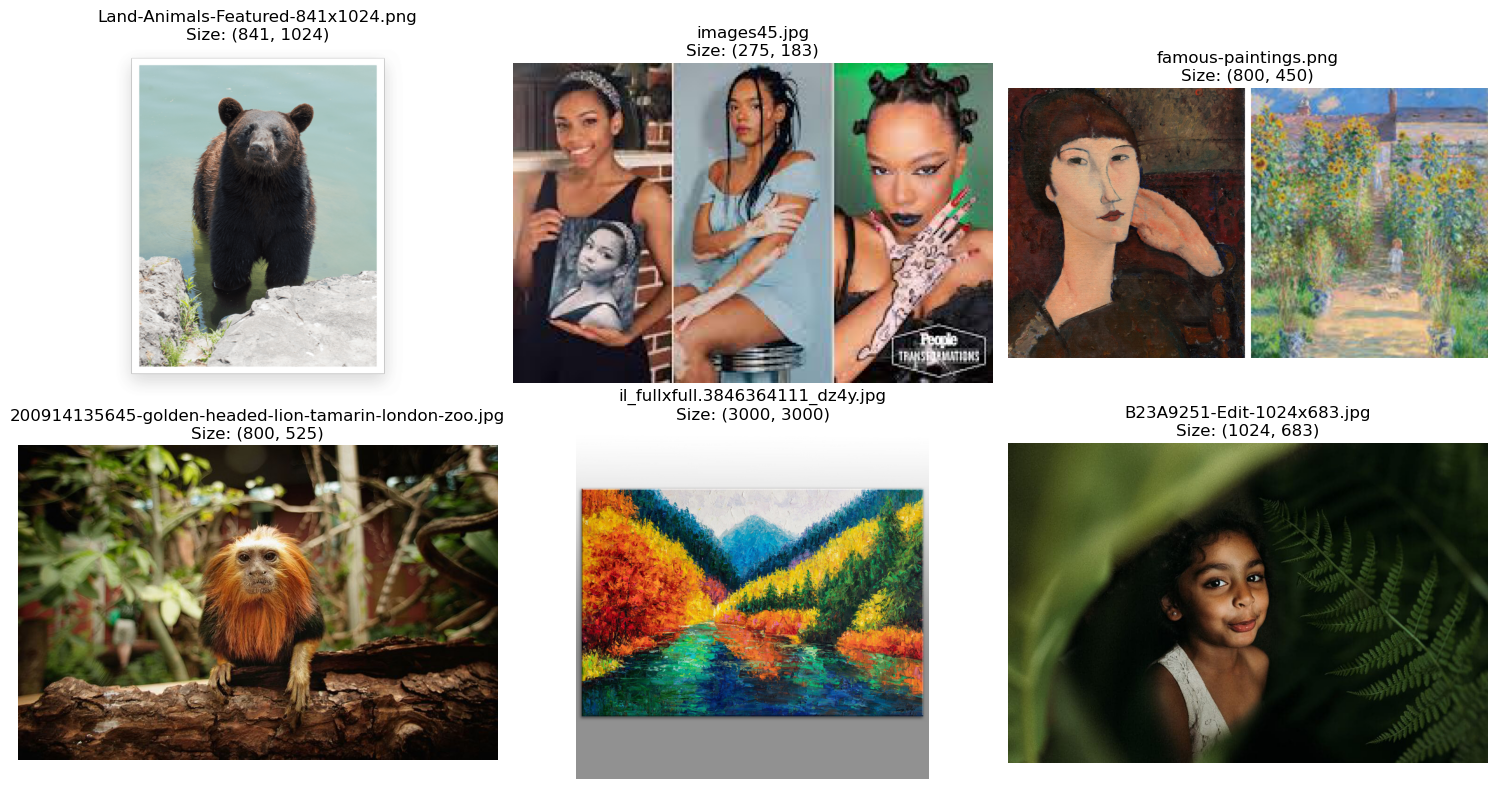

In [8]:
real_images_data = []
for file in no_ext_files:
    real_images_data.append(file)
# Add extensions
for ext in ['*.jpg', '*.jpeg', '*.png', '*.webp']:
    real_images_data.extend(real_data_path.glob(ext))
print(f"{len(real_images_data)} Real images found.\n")

if real_images_data:
    # Display 6 random images in a grid
    display_random_images(real_images_data, 6)
else:
    print("No images found in the directory")

## Image properties inspection

We will now inspect the properties of an image so that we can notice if there is anything important to take into consideration during pre-processing. We first define our function which will print general image statistics given the image's path

In [9]:
# Function to print general image statistics
def inspect_image(image_path, label):
    image_prototype = Image.open(image_path)

    img_np = np.array(image_prototype)
    channels = 1 if len(img_np.shape) == 2 else img_np.shape[2]
    print(
        f"{label} Image Prototype\n"
        "\n"
        f"Format: {image_prototype.format}\n"
        f"Mode:   {image_prototype.mode}\n"
        f"Size:   {image_prototype.size}\n"
        f"Channels: {channels}\n"
        f"Min pixel value: {img_np.min()}\n"
        f"Max pixel value: {img_np.max()}\n"
        f"Mean pixel value: {img_np.mean()}\n"
        f"Std pixel value: {img_np.std()}\n"  
    )
    if img_np.ndim == 3:
            for i, c in enumerate(["R", "G", "B"]):
                print(f"{c} mean: {img_np[..., i].mean():.2f}, "
                    f"{c} std: {img_np[..., i].std():.2f}")
    print("--------------------")
    return image_prototype



We now call our newly defined function for 10 random images per class so that we can spot differences

In [10]:

for i in range(10):
    ai_image_prototype = inspect_image(random.choice(ai_images_data), "AI-generated")
    real_image_prototype = inspect_image(random.choice(real_images_data), "Real")


AI-generated Image Prototype

Format: PNG
Mode:   RGB
Size:   (1400, 933)
Channels: 3
Min pixel value: 0
Max pixel value: 255
Mean pixel value: 75.00077987036187
Std pixel value: 53.22530790542497

R mean: 102.64, R std: 65.34
G mean: 66.39, G std: 44.54
B mean: 55.98, B std: 32.33
--------------------
Real Image Prototype

Format: JPEG
Mode:   RGB
Size:   (720, 720)
Channels: 3
Min pixel value: 0
Max pixel value: 255
Mean pixel value: 120.08570280349794
Std pixel value: 74.22459038251618

R mean: 134.97, R std: 75.88
G mean: 120.11, G std: 67.42
B mean: 105.18, B std: 76.02
--------------------
AI-generated Image Prototype

Format: JPEG
Mode:   RGB
Size:   (1960, 1960)
Channels: 3
Min pixel value: 0
Max pixel value: 255
Mean pixel value: 99.29431434818825
Std pixel value: 78.71984114345204

R mean: 79.41, R std: 81.80
G mean: 103.04, G std: 75.26
B mean: 115.43, B std: 74.60
--------------------
Real Image Prototype

Format: JPEG
Mode:   RGB
Size:   (564, 700)
Channels: 3
Min pixel va

 - We can clearly see that there is a large imbalance in the size of the images (width, height). Our model might learn these differences and classify images as AI just based on their size. This is something we want to avoid at all costs so we will have to pick one size and resize all images
 - Most of the images that we see over the iterations are RGB, but we can not conclude that there are not any images that have a different mode
 - Futhermore images have different means and stds, which we should also take into consideration when normalizing the data. It could be the case that AI images are brighter than Real ones, but we should avoid making a decision only based on this

### Dataset Plots
We will now create several plots to summarize and confirm the differences that we saw in the last cell

## 1. Width and Height Histogram
Since we noted that this might be the biggest problem in our classification model, we will now insect them next to each other

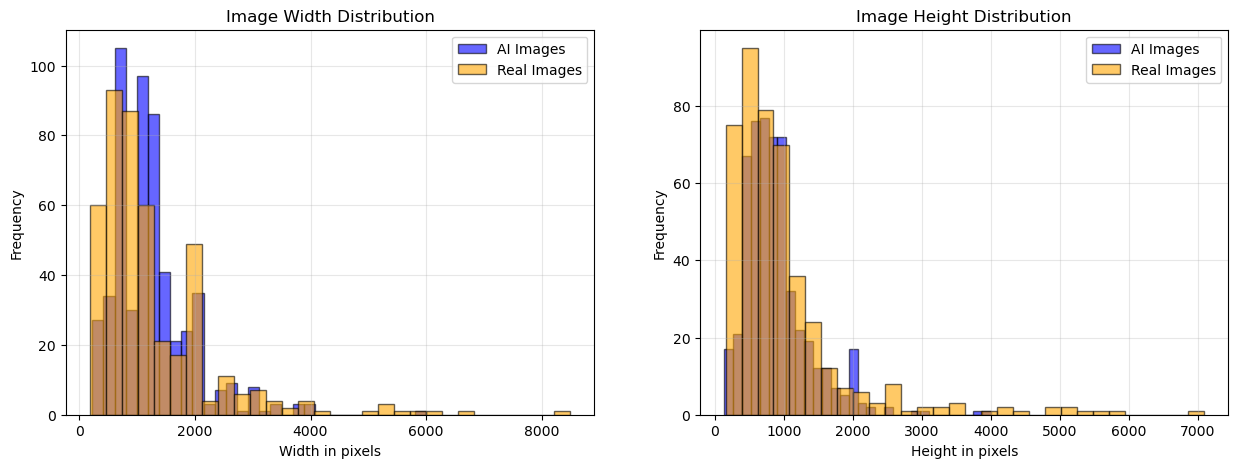

Width Statistics:
  AI Images - Mean: 1227.20, Std: 684.11, Min: 225, Max: 6000
  Real Images - Mean: 1253.24, Std: 1045.02, Min: 183, Max: 8495

Height Statistics:
  AI Images - Mean: 899.19, Std: 485.55, Min: 135, Max: 4001
  Real Images - Mean: 992.88, Std: 924.58, Min: 158, Max: 7091


In [11]:
# Collect width and height information for both datasets
ai_widths = []
ai_heights = []
real_widths = []
real_heights = []

# Extract dimensions from AI images
for img_path in ai_images_data:
    img = Image.open(img_path)
    ai_widths.append(img.size[0])
    ai_heights.append(img.size[1])

# Extract dimensions from Real images
for img_path in real_images_data:
    img = Image.open(img_path)
    real_widths.append(img.size[0])
    real_heights.append(img.size[1])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Width histogram
axes[0].hist(ai_widths, bins=30, alpha=0.6, label='AI Images', color='blue', edgecolor='black')
axes[0].hist(real_widths, bins=30, alpha=0.6, label='Real Images', color='orange', edgecolor='black')
axes[0].set_xlabel('Width in pixels')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Image Width Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Height histogram
axes[1].hist(ai_heights, bins=30, alpha=0.6, label='AI Images', color='blue', edgecolor='black')
axes[1].hist(real_heights, bins=30, alpha=0.6, label='Real Images', color='orange', edgecolor='black')
axes[1].set_xlabel('Height in pixels')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Image Height Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.show()

# Print summary statistics
print("Width Statistics:")
print(f"  AI Images - Mean: {np.mean(ai_widths):.2f}, Std: {np.std(ai_widths):.2f}, Min: {np.min(ai_widths)}, Max: {np.max(ai_widths)}")
print(f"  Real Images - Mean: {np.mean(real_widths):.2f}, Std: {np.std(real_widths):.2f}, Min: {np.min(real_widths)}, Max: {np.max(real_widths)}")
print("\nHeight Statistics:")
print(f"  AI Images - Mean: {np.mean(ai_heights):.2f}, Std: {np.std(ai_heights):.2f}, Min: {np.min(ai_heights)}, Max: {np.max(ai_heights)}")
print(f"  Real Images - Mean: {np.mean(real_heights):.2f}, Std: {np.std(real_heights):.2f}, Min: {np.min(real_heights)}, Max: {np.max(real_heights)}")

- As we can see both max width and max height are bigger for the Real Images. This means that on average AI-generated images are smaller in comparison with Real ones.
- Variance is huge in both classes. 
- There are long heavy tails, especially for the real images.
- There exist outliers - up to 8500 px wide and 7000 px tall

The dataset inspection shows large variability in image resolutions with heavy-tailed distributions, particularly for real images. This constitutes a potential shortcut cue for CNNs. Therefore, we must standardize image resolution during preprocessing.

## Preprocessing

We now start with preprocessing which will enable us to work with the images in such a way that there is no involved bias.

As we said Width/height distributions show heavy variability and long tails, especially for real images. This is a potential shortcut cue. Therefore we standardize input resolution during preprocessing.


We need to convert our images to tensors so that our Convolutional Neural Network can use them. To do so , we convert all images to RGB, so that all of them are in the same color mode. Then we resize them to 224 x 224 using bilineear interpolation. By using Bilinear Interpolation we average the pixels together and scale the image down while preserving information about the image.

We now create our pipeline that will transform an image into a tensor so that our CNN can be used correctly

In [12]:
image_to_tensor = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
    transforms.ToTensor(),
])

# Here we print some basic statistics about the transformation so that we can verify it is correct
img = Image.open(ai_images_data[0])
print("Before:", img.mode, img.size, type(img))

x = image_to_tensor(img)
print("After:", x.shape, x.dtype, x.min().item(), x.max().item(), type(x))

Before: RGB (1200, 800) <class 'PIL.JpegImagePlugin.JpegImageFile'>
After: torch.Size([3, 224, 224]) torch.float32 0.0 1.0 <class 'torch.Tensor'>


The transformation has transformed the image into a 224x224 with 3 channels - mainly RGB

## Convolutional Neural Network From Scratch

Before using any deep learning frameworks, we will implement a small CNN from scratch following standard convolution and backpropagation formulations, in order to understand how spatial features are learned and to observe the limitations of manual implementations. We are expecting our CNN to work very slow, so therefore we will test it only on a very small subset of our data

*Note: The manually implemented CNN is not evaluated as a competitive classifier. Instead, it serves as an educational baseline to analyze learning dynamics, overfitting behavior, and the impact of preprocessing, which motivates the use of framework-based models such as PyTorch.*

### 1. Preprocessing

We will first preprocess our data since our images have a mean of 1200x1000 which would be too computationally expensive for a manual implementation of CNN, because of its limitations. 

Therefore we would transform our images drastically:
 - we will convert the images to greyscale so that we can focus purely on spatial features such as edges, textures and local patterns
 - we will compress our images to 32x32 in order to make the CNN computationally less expensive. We will be using for loops to make the backpropagation and forward passes explicit. Therefore we want to avoid working with very large data

In [13]:
img_size = 32

# Function to load and preprocess an image for manual CNN
def load_and_preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.convert("L") # Convert to grayscale
    img = img.resize((img_size, img_size), Image.BILINEAR) # Resize image
    img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize to [0, 1]
    return img_array


We will now transform our dataset by transforming the image and appending a label to each image (1 = AI-generated, 0 = Real)

In [14]:
manual_cnn_data = []
manual_cnn_data_labels = []

for img_path in ai_images_data:
    img_array = load_and_preprocess_image(img_path)
    manual_cnn_data.append(img_array)
    manual_cnn_data_labels.append(1)  # Label 1 for AI-generated images

for img_path in real_images_data:
    img_array = load_and_preprocess_image(img_path)
    manual_cnn_data.append(img_array)
    manual_cnn_data_labels.append(0)  # Label 0 for Real images

manual_cnn_data = np.array(manual_cnn_data)
manual_cnn_data_labels = np.array(manual_cnn_data_labels)

/opt/homebrew/anaconda3/lib/python3.13/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


We will now print the shapes of our dataset and labels to ensure they are in the correct format:
-  (N, 32, 32) - meaning we have N images which are 32x32

In [15]:
print(manual_cnn_data.shape)
print(manual_cnn_data_labels.shape)

(974, 32, 32)
(974,)


Before proceeding with our pipeline, we will print the original image with the preprocessed one next to each other to see the effect of our preprocessing

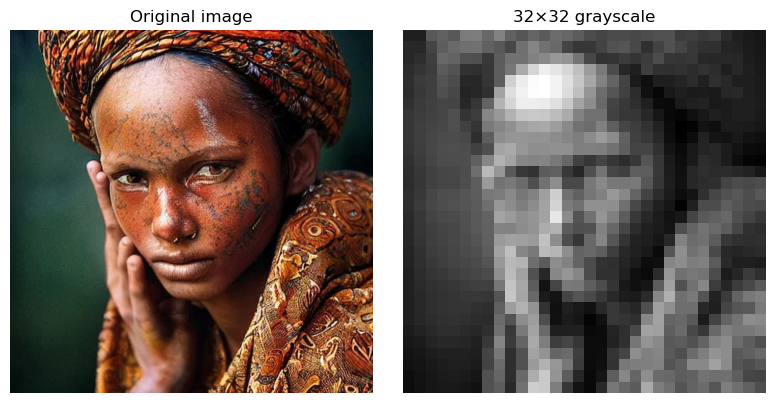

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Original image
axes[0].imshow(Image.open(ai_images_data[1]))
axes[0].set_title("Original image")
axes[0].axis("off")

# Preprocessed
axes[1].imshow(manual_cnn_data[1], cmap="gray")
axes[1].set_title("32×32 grayscale")
axes[1].axis("off")

plt.tight_layout()
plt.show()


Furthermore we will shuffle the images and split to train and test sets. We do not necessarily need a validation set, since as I said the scratch CNN is used for educational purposes and therefore the parameters, such as learning rate and number of filters, will be fixed. We will be using 20/80 test/train split

In [17]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    manual_cnn_data,
    manual_cnn_data_labels,
    test_size=0.2,
    random_state=42,
    stratify=manual_cnn_data_labels
)

We will now print some of the images to see if everything is in order

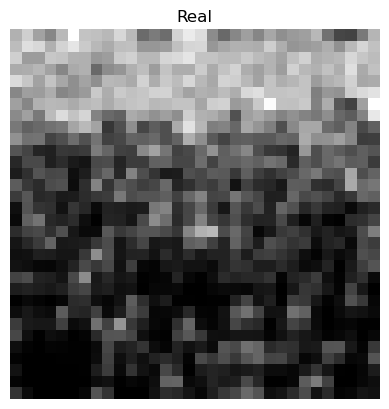

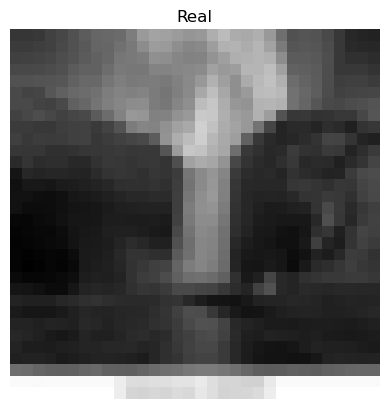

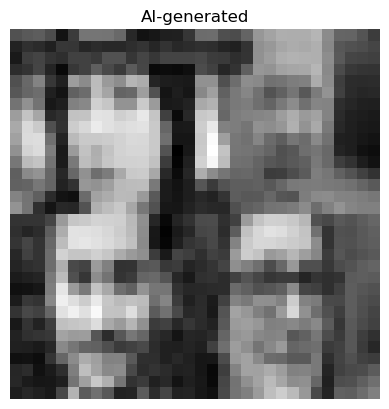

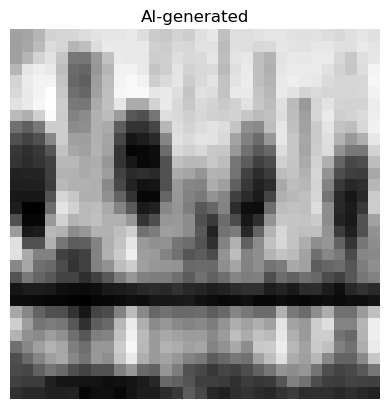

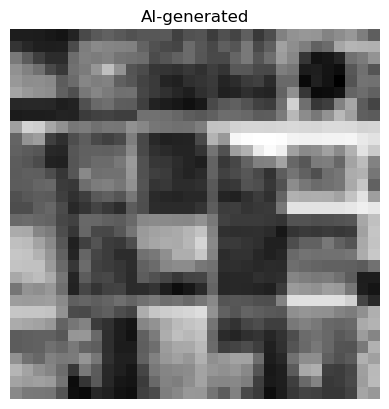

In [18]:
idx = np.random.permutation(len(x_train))
for i in idx[:5]:
    plt.imshow(x_train[i], cmap="gray")
    plt.title("AI-generated" if y_train[i] == 1 else "Real")
    plt.axis("off")
    plt.show()

## Layers

### 2.1 Convolutional Layer

We will not start implementing the convolution layer class

In [19]:
class Conv3x3:
    def __init__(self, num_filters):
        self.num_filters = num_filters
        # Initialize filters with small random values
        # We will divide by 9 to normalize the filter values and reduce their variance
        self.filters = np.random.randn(num_filters, 3, 3) / 9

    # Function to generate the possible 3x3 regions of the input image
    # Returns the region, the top-left x coordinate, and the top-left y coordinate
    def iterate_regions(self, image):
        
        h, w = image.shape

        for i in range(h - 2):
            for j in range(w - 2):
                im_region = image[i:(i + 3), j:(j + 3)]
                yield im_region, i, j # This returns a generator so we dont have to store the full list in memory

    # Function which applies the filters onto the image and returns the convolved output
    def forward(self, input):
        self.last_input = input
        h, w = input.shape
        output = np.zeros((h - 2, w - 2, self.num_filters)) # Output height and width will be reduced by 2
        for im_region, i, j in self.iterate_regions(input):
            output[i, j] = np.sum(im_region * self.filters, axis=(1, 2)) 
            # Convolve the filter over the region using dimensions 2 and 3 since the first dimension is not used
            # shape is (num_filters, 3,3) so we want to sum over the last two dimensions
        return output
    
    def backward(self, dL_dout):
        dL_dinput = np.zeros(self.last_input.shape)
        self.dfilters = np.zeros(self.filters.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            for f in range(self.num_filters):
                # Filter gradient
                self.dfilters[f] += dL_dout[i, j, f] * im_region

                # Input gradient
                dL_dinput[i:i+3, j:j+3] += dL_dout[i, j, f] * self.filters[f]

        return dL_dinput



We now run it with one sample to insect the shape of the image. It should be (30,30,8) denoting that our image has decreased its height and width by 2. We have an output of the image for each filter

In [20]:
conv = Conv3x3(8)  # 8 filters
output = conv.forward(x_train[0])
print("Input shape:", x_train[0].shape)
print("Output shape:", output.shape)

Input shape: (32, 32)
Output shape: (30, 30, 8)


### 2.2 RELU Layer

We are going to introduce a RELU layer as an intermediatery layer, since without it we are just combining linear models and therefore our final CNN model would also be lineear. However, image classification requires non-linear feature composition and RELU helps with that

In [21]:
class RELU:
    def forward(self, input):
        self.last_input = input
        temp = np.maximum(0, input)
        return temp
    
    def backward(self, dl_dinput):
        # Derivative of the ReLU function is 1 for positive inputs and 0 for negative inputs
        relu_grad = self.last_input > 0
        return dl_dinput * relu_grad

### 2.3 Pooling Layer

Next step is the pooling layer which will compress the result even more. It divides the input's width and height by the pool size. For our case we will use a Max Pooling Layer which will get the maximum value of the area where the filter is applied

In [22]:
# Class for 2x2 max pooling
class MaxPool2:
    
    # Function to generate the possible 2x2 regions of the input image
    def iterate_regions(self, image):
        h, w, _ = image.shape

        for i in range(h // 2):
            for j in range(w // 2):
                im_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
                yield im_region, i, j

    # Function which applies max pooling to the input image
    def forward(self, input):
        self.last_input = input
        h, w, num_filters = input.shape
        output = np.zeros((h // 2, w // 2, num_filters))

        for im_region, i, j in self.iterate_regions(input):
            output[i, j] = np.amax(im_region, axis=(0, 1))  # Max pooling over the 2x2 region of dimensions 0 and 1
        return output
    
    def backward(self, dL_dout):
        dL_dinput = np.zeros(self.last_input.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            h_start = i * 2
            w_start = j * 2

            for f in range(dL_dout.shape[2]):
                max_val = np.max(im_region[:, :, f]) # Find the max value in the current region for the current filter

                for wi in range(2):
                    for wj in range(2):
                        if im_region[wi, wj, f] == max_val: # Check if the current value is the max value
                            dL_dinput[h_start + wi, w_start + wj, f] = dL_dout[i, j, f] # Propagate the gradient to the position of the max value

        return dL_dinput

We will now test our implementation again, but now using the MaxPool2 after the Convolution Layer. Its shape should be (15, 15, 8), since we are compressing it to make it twice as small

In [23]:
pool = MaxPool2()
output = pool.forward(output)
print("Output shape:", output.shape)

Output shape: (15, 15, 8)


### 2.4 Fully Connected Layer
We will now create our class which represents the fully connected layer. By now, our current output is a (15, 15, 8) representing 8 filters with 15x15 image. We need to flatten this 3-dimensional array and output 1 number which will be then fed into our sigmoid function which would output the probability of the image being AI-generated

In [34]:
class FullyConnected:
    def __init__(self, input_size):
        # Initialize weights and biases
        self.weights = np.random.randn(input_size) * 0.01
        self.bias = 0.0

    def forward(self, input):
        # Flatten the input
        self.input = input
        # Compute the output
        output = np.dot(self.weights, self.input) + self.bias
        return output
    
    def backward(self, dl_dz):
        # Compute gradients
        self.dweights = dl_dz * self.input # Gradient of loss with respect to weights
        self.dbias = dl_dz # Gradient of loss with respect to bias
        return dl_dz * self.weights # Gradient of loss with respect to input



In [25]:
fully_connected = FullyConnected(output.size)
output = fully_connected.forward(output.flatten())
print("Output size after Fully Connected layer:", output.size)

Output size after Fully Connected layer: 1


### 2.4 Final Activation Layer

To finalize our forward passes, we need to give our model the ability to make predictions. Since we have only two classes in our dataset - Ai-generated (1) or Real (0), then we can use the sigmoid function and the binary cross-entropy. The reason is because sigmoid outputs 1 neuron - the probability of having this imaged classified as Ai or Real and therefore the opposite probability would just be 1 - this probability.

If we had more than 2 classes, then the correct choice would be Softmax since it predicts probabilities for more than 2 classes.

As for the backwards pass:
 - The input to the function would be the derivative of the loss with respect to the output of the sigmoid => dL/dp
 - The output of the function would be the derivative of the loss with respect to the input of the sigmoid => dL/dz
 - Therefore each layer would "apply" its derivative to the overall derivative
 - Since we need the output of the sigmoid for the backwards pass, we need to store the output of the sigmoid function during the forward pass


In [26]:
class Sigmoid:
    def forward(self, input):
        self.out =  1 / (1 + np.exp(-input))
        return self.out
    
    def backward(self, dl_dp):
        # Derivative of the sigmoid function is just out * (1 - out)
        # And we multiply this with the derivative of the loss with respect to the prediction, which is given as input to the function
        return dl_dp * (self.out * (1 - self.out))

## 2.5 Combined Model
We will now create our main CNN class which combines our full pipeline into one. It will be responsible for forward and backward passes (which are not implemented yet)


In [ ]:
class CNN:
    def __init__(self, num_filters=8):
        self.conv = Conv3x3(num_filters=num_filters)  # 8 filters
        self.relu = RELU()
        self.pool = MaxPool2()
        self.fc = FullyConnected(15 * 15 * num_filters)  # Adjusted for 32x32 input size
        self.sigmoid = Sigmoid()

    def forward(self, input):
        output = self.conv.forward(input)
        output = self.relu.forward(output)
        output = self.pool.forward(output)
        self.last_shape = output.shape  # Store shape for backward pass
        output = output.flatten()
        output = self.fc.forward(output)
        output = self.sigmoid.forward(output)
        return output
    
    def backward(self, dl_dout, learning_rate=0.001):
        dl_dout = self.sigmoid.backward(dl_dout)
        dl_dout = self.fc.backward(dl_dout)
        dl_dout = dl_dout.reshape(self.last_shape)  # Reshape to match pooled output dimensions
        dl_dout = self.pool.backward(dl_dout)
        dl_dout = self.relu.backward(dl_dout)
        dl_dout = self.conv.backward(dl_dout)
        # Update weights and biases
        self.fc.weights -= learning_rate * self.fc.dweights
        self.fc.bias -= learning_rate * self.fc.dbias
        self.conv.filters -= learning_rate * self.conv.dfilters
        return None

### 2.6 Loss Function
Futhermore we will be using the Cross-Entropy Loss Function since its especially suitable for binary classification. Since we have ony 2 classes - Ai-generated (1) and Real (0), this is the perfect loss function to use.

In [28]:
def binary_cross_entropy_loss(prediction, label):
        # Avoid log(0) by adding a small epsilon
        epsilon = 1e-12
        prediction = np.clip(prediction, epsilon, 1.0 - epsilon) # Values that are 0 are mapped to epsilon, values that are 1 are mapped to 1-epsilon
        loss = - (label * np.log(prediction) + (1 - label) * np.log(1 - prediction))
        return loss

def binary_cross_entropy_grad(prediction, label):
    # Avoid division by zero
    epsilon = 1e-12
    prediction = np.clip(prediction, epsilon, 1.0 - epsilon)
    return - (label / prediction) + (1 - label) / (1 - prediction)

We define more functions which will be of importance to us, such as predicting the class based on some threshold and computing the accuracy

In [29]:
def predict_class(p, threshold = 0.5):
    return 1 if p >= threshold else 0

def compute_accuracy(predictions, labels, threshold=0.5):
    correct = 0
    for p, y in zip(predictions, labels):
        predicted_class = predict_class(p, threshold)
        if predicted_class == y:
            correct += 1
    accuracy = correct / len(labels)
    return accuracy

We run our model on the train set to see what accuracy we are getting and comment on it

In [30]:
model = CNN(num_filters=8)
total_loss = 0

predictions = []
for image, label in zip(x_train, y_train):
    p = model.forward(image)
    loss = binary_cross_entropy_loss(p, label)
    total_loss += loss
    predictions.append(p)
avg_loss = total_loss / len(x_train)
acc = compute_accuracy(predictions, y_train)
print(f"Measuring Loss and Accuracy on the Training Set: loss={avg_loss:.4f}, acc={acc * 100} % ")

Measuring Loss and Accuracy on the Training Set: loss=0.6931, acc=50.70603337612324 % 


At this stage, the CNN performs only forward passes with randomly initialized parameters. As expected, the loss remains close to the binary cross-entropy of random guessing (≈ 0.69), while accuracy fluctuates around the class-imbalance baseline (We have around 539 AI images and 450 real ones). Since no backpropagation or parameter updates are applied, the model does not learn.

## 2.7 Backpropagation

We will now create our function for training our scratch CNN that we created. We defined it for an input of the model, train set, label train set, number of epochs and the learning rate.

In [31]:
# Function to perform a single training step, meaning forward and backward pass for one image
def train_step(model, image, label, lr):
    p = model.forward(image)
    loss = binary_cross_entropy_loss(p, label)
    dL_dp = binary_cross_entropy_grad(p, label)
    model.backward(dL_dp, lr)
    return p, loss

# Function to train the model for one epoch over the entire training set
def train_epoch(model, x_train, y_train, lr):
    total_loss = 0
    predictions = []

    for image, label in zip(x_train, y_train):
        p, loss = train_step(model, image, label, lr)
        total_loss += loss
        predictions.append(p)

    avg_loss = total_loss / len(x_train)
    train_acc = compute_accuracy(predictions, y_train)

    return avg_loss, train_acc

def train(model, x_train, y_train, epochs=5, lr=0.01):
    for epoch in range(epochs):
        avg_loss, acc = train_epoch(model, x_train, y_train, lr)

        print(f"Epoch {epoch+1}: loss={avg_loss:.4f}, acc={acc*100:.2f}%")

Now we will run several pipelines to ensure that it works as expected

Note: It is important to create a new instance of CNN every time since weights are updated in place and therefore we need to start fresh everytime


## 2.8 Training our model

### 2.8.1 Tiny set overfit
As a sanity check, we train the network on only 10 samples and should observe rapid convergence to 100% accuracy with steadily decreasing loss, confirming that the forward and backward passes were implemented correctly. Here we dont evaluate on the test set, since we want ot confirm that our gradient descend and backwards passes are working correctly

In [131]:
new_model = CNN(num_filters=8)
train(model, x_train[:10], y_train[:10], epochs=50, lr=0.01)

Epoch 1: loss=0.3836, acc=80.00%
Epoch 2: loss=0.1157, acc=100.00%
Epoch 3: loss=0.0679, acc=100.00%
Epoch 4: loss=0.0497, acc=100.00%
Epoch 5: loss=0.0396, acc=100.00%
Epoch 6: loss=0.0331, acc=100.00%
Epoch 7: loss=0.0286, acc=100.00%
Epoch 8: loss=0.0252, acc=100.00%
Epoch 9: loss=0.0225, acc=100.00%
Epoch 10: loss=0.0203, acc=100.00%
Epoch 11: loss=0.0185, acc=100.00%
Epoch 12: loss=0.0171, acc=100.00%
Epoch 13: loss=0.0158, acc=100.00%
Epoch 14: loss=0.0147, acc=100.00%
Epoch 15: loss=0.0137, acc=100.00%
Epoch 16: loss=0.0129, acc=100.00%
Epoch 17: loss=0.0121, acc=100.00%
Epoch 18: loss=0.0115, acc=100.00%
Epoch 19: loss=0.0109, acc=100.00%
Epoch 20: loss=0.0103, acc=100.00%
Epoch 21: loss=0.0098, acc=100.00%
Epoch 22: loss=0.0094, acc=100.00%
Epoch 23: loss=0.0090, acc=100.00%
Epoch 24: loss=0.0086, acc=100.00%
Epoch 25: loss=0.0082, acc=100.00%
Epoch 26: loss=0.0079, acc=100.00%
Epoch 27: loss=0.0076, acc=100.00%
Epoch 28: loss=0.0073, acc=100.00%
Epoch 29: loss=0.0070, acc=100

We can see that although accuracy stays at 100%, the loss decreases. The reason is because we defined our accuracy function with a threshold of 0.5. Therefore loss will keep decreasing but accuracy will stay the same

### 2.8.2 Slightly bigger input
We now move on to a slightly bigger dataset and see if it converges correctly. We do this to ensure that the model can converge to the right parameters beyond a trivial case.

In [118]:
new_model = CNN(num_filters=8)
train(new_model, x_train[:50], y_train[:50], epochs=50, lr=0.01)

Epoch 1: loss=0.7020, acc=54.00%
Epoch 2: loss=0.7057, acc=56.00%
Epoch 3: loss=0.6915, acc=56.00%
Epoch 4: loss=0.6826, acc=58.00%
Epoch 5: loss=0.6762, acc=62.00%
Epoch 6: loss=0.6707, acc=64.00%
Epoch 7: loss=0.6653, acc=64.00%
Epoch 8: loss=0.6593, acc=66.00%
Epoch 9: loss=0.6524, acc=68.00%
Epoch 10: loss=0.6441, acc=68.00%
Epoch 11: loss=0.6342, acc=68.00%
Epoch 12: loss=0.6227, acc=72.00%
Epoch 13: loss=0.6102, acc=72.00%
Epoch 14: loss=0.5959, acc=74.00%
Epoch 15: loss=0.5794, acc=78.00%
Epoch 16: loss=0.5617, acc=80.00%
Epoch 17: loss=0.5429, acc=80.00%
Epoch 18: loss=0.5229, acc=80.00%
Epoch 19: loss=0.5025, acc=80.00%
Epoch 20: loss=0.4814, acc=82.00%
Epoch 21: loss=0.4602, acc=84.00%
Epoch 22: loss=0.4391, acc=84.00%
Epoch 23: loss=0.4190, acc=84.00%
Epoch 24: loss=0.3997, acc=84.00%
Epoch 25: loss=0.3811, acc=86.00%
Epoch 26: loss=0.3635, acc=90.00%
Epoch 27: loss=0.3465, acc=90.00%
Epoch 28: loss=0.3304, acc=90.00%
Epoch 29: loss=0.3151, acc=90.00%
Epoch 30: loss=0.3005, 

Based on our results we can tell that our model updates its parameters correctly, since accuracy is increaseing and loss is decreasing

### 2.8.3 Learning Rate Observations

We will now train the model several times with different learning rates in order to see their impact to our model. We should see large differences between the large and small value of the learning rate since gradient descend will fluctuate instead of converge to the optimal value

We will be using only a few epochs to avoid computations which would otherwise take a lot of time

But before that we define some functions that will be of great use to us

In [32]:
# Function to evaluate the model on a given dataset
def evaluate(model, x, y):
    total_loss = 0
    predictions = []

    for image, label in zip(x, y):
        p = model.forward(image)  # forward ONLY
        total_loss += binary_cross_entropy_loss(p, label)
        predictions.append(p)

    avg_loss = total_loss / len(x)
    acc = compute_accuracy(predictions, y)

    return avg_loss, acc

#Function to train the model with logging of training and test accuracy per epoch
def train_with_logging(model, x_train, y_train, x_test, y_test, epochs=5, lr=0.01):
    train_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, x_train, y_train, lr)
        _, test_acc = evaluate(model, x_test, y_test)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
    
        print(
            f"Epoch {epoch+1}: "
            f"loss={train_loss:.4f}, "
            f"train_acc={train_acc*100:.2f}%, "
            f"test_acc={test_acc*100:.2f}%"
        )

    return train_losses, train_accs, test_accs

In [153]:
model = CNN(num_filters=8)

# Learning rate of 0.01
train_losses, train_accs, test_accs = train_with_logging(
    model,
    x_train,
    y_train,
    x_test,
    y_test,
    epochs=5,
    lr=0.01
)


Epoch 1: loss=0.6921, train_acc=54.04%, test_acc=55.38%
Epoch 2: loss=0.6847, train_acc=55.33%, test_acc=55.38%
Epoch 3: loss=0.6800, train_acc=55.46%, test_acc=56.41%
Epoch 4: loss=0.6714, train_acc=58.92%, test_acc=67.69%
Epoch 5: loss=0.6571, train_acc=61.87%, test_acc=64.62%


In [155]:
model = CNN(num_filters=8)

# Learning rate of 0.1
train_losses, train_accs, test_accs = train_with_logging(
    model,
    x_train,
    y_train,
    x_test,
    y_test,
    epochs=5,
    lr=0.1
)

Epoch 1: loss=0.6970, train_acc=53.53%, test_acc=55.38%
Epoch 2: loss=0.6958, train_acc=54.30%, test_acc=55.38%
Epoch 3: loss=0.6968, train_acc=54.69%, test_acc=55.38%
Epoch 4: loss=0.6952, train_acc=54.17%, test_acc=55.38%
Epoch 5: loss=0.6945, train_acc=54.04%, test_acc=55.90%


We can see that having a larger learning rate causes our accuracy to stay around the same level. This could be due to gradient descend not converging properly as I said but fluctuating left and right on the curve

### 2.7.3 Final training and plots

We will now properly train our model using all of our training set. We will be using the following functions and the 80/20 train/test split

In [38]:
model = CNN(num_filters=8)

train_losses, train_accs, test_accs = train_with_logging(
    model,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    epochs=20,
    lr=0.01
)


Epoch 1: loss=0.6910, train_acc=54.69%, test_acc=55.38%
Epoch 2: loss=0.6865, train_acc=55.33%, test_acc=55.38%
Epoch 3: loss=0.6843, train_acc=55.33%, test_acc=55.38%
Epoch 4: loss=0.6808, train_acc=55.33%, test_acc=55.38%
Epoch 5: loss=0.6749, train_acc=55.33%, test_acc=58.97%
Epoch 6: loss=0.6660, train_acc=58.66%, test_acc=61.54%
Epoch 7: loss=0.6546, train_acc=63.54%, test_acc=62.56%
Epoch 8: loss=0.6395, train_acc=65.21%, test_acc=63.08%
Epoch 9: loss=0.6221, train_acc=67.14%, test_acc=64.62%
Epoch 10: loss=0.6044, train_acc=68.68%, test_acc=64.10%
Epoch 11: loss=0.5877, train_acc=69.96%, test_acc=63.59%
Epoch 12: loss=0.5692, train_acc=71.25%, test_acc=63.08%
Epoch 13: loss=0.5528, train_acc=73.17%, test_acc=64.10%
Epoch 14: loss=0.5366, train_acc=74.33%, test_acc=65.13%
Epoch 15: loss=0.5215, train_acc=75.48%, test_acc=65.64%
Epoch 16: loss=0.5056, train_acc=76.64%, test_acc=66.67%
Epoch 17: loss=0.4900, train_acc=77.28%, test_acc=66.67%
Epoch 18: loss=0.4749, train_acc=78.05%,

We now plot the training loss for each epoch of the previous training iteration.

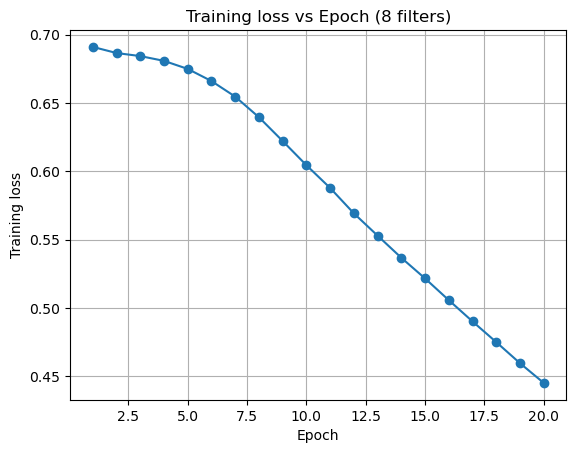

In [39]:
epochs = range(1, len(train_losses) + 1)

plt.figure()
plt.plot(epochs, train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.title("Training loss vs Epoch (8 filters)")
plt.grid(True)
plt.show()

We can see that there is an obvious trend of training loss decreasing with every epoch - as expected

The next plot can help us analyze our model by plotting the accuracies for train and test sets for each epoch

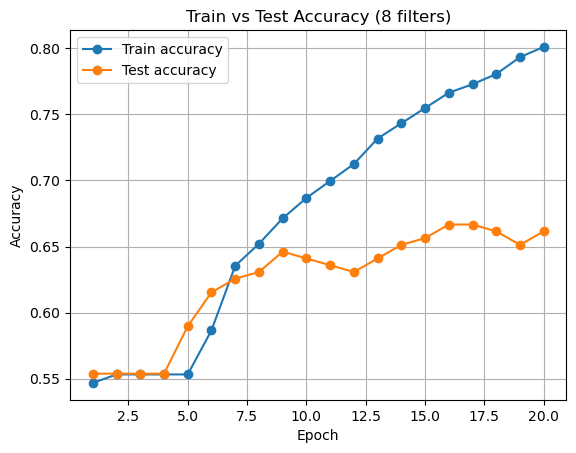

In [40]:
plt.figure()
plt.plot(epochs, train_accs, label="Train accuracy", marker='o')
plt.plot(epochs, test_accs, label="Test accuracy", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy (8 filters)")
plt.legend()
plt.grid(True)
plt.show()

### 2.7.4 16 filters check

We will now test our model after training it on 16 filters in order to see if it performs better


In [33]:
model = CNN(num_filters=16)

train_losses, train_accs, test_accs = train_with_logging(
    model,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    epochs=20,
    lr=0.01
)

Epoch 1: loss=0.6901, train_acc=54.56%, test_acc=55.38%
Epoch 2: loss=0.6784, train_acc=55.20%, test_acc=56.41%
Epoch 3: loss=0.6701, train_acc=58.28%, test_acc=62.05%
Epoch 4: loss=0.6590, train_acc=62.00%, test_acc=64.62%
Epoch 5: loss=0.6453, train_acc=64.83%, test_acc=64.10%
Epoch 6: loss=0.6300, train_acc=64.70%, test_acc=65.13%
Epoch 7: loss=0.6129, train_acc=66.50%, test_acc=65.64%
Epoch 8: loss=0.5957, train_acc=67.65%, test_acc=65.64%
Epoch 9: loss=0.5785, train_acc=70.35%, test_acc=64.62%
Epoch 10: loss=0.5624, train_acc=70.22%, test_acc=64.62%
Epoch 11: loss=0.5462, train_acc=72.14%, test_acc=66.15%
Epoch 12: loss=0.5300, train_acc=73.04%, test_acc=66.15%
Epoch 13: loss=0.5146, train_acc=75.22%, test_acc=67.69%
Epoch 14: loss=0.4982, train_acc=75.74%, test_acc=68.72%
Epoch 15: loss=0.4828, train_acc=76.51%, test_acc=69.74%
Epoch 16: loss=0.4682, train_acc=77.66%, test_acc=70.77%
Epoch 17: loss=0.4528, train_acc=78.82%, test_acc=69.74%
Epoch 18: loss=0.4384, train_acc=79.33%,

### Conclusion

*Note: Its important to note that due to random initializations of the weights at the start of the training of the model, the plots can look different every time. Nevertheless we got to the following conclusions*

The manual implementation of our Convolutional Neural Network achieved a peak test accuracy of approximately 67–68% during training. While training accuracy continued to increase with additional epochs, test accuracy plateaued rather than degrading, indicating that the model does not exhibit severe overfitting in this configuration.

- The consistent decrease in training loss across epochs confirms the correctness of the backpropagation and gradient descent implementations. 

- However, the early saturation of test accuracy suggests that the model is limited by its representational capacity rather than by insufficient training.

- Loss Convergence -  The training loss decreased consistently throughout all 20 epochs, confirming that the backpropagation and gradient descent algorithms were implemented correctly.

- When comparing the model's performance between lr=0.01 and lr=0.1 over 5 epochs, the following observations were made:
    1. lr = 0.01:  This learning rate allowed for a steady decrease in loss (from 0.6921 to 0.6571) and a clear improvement in training accuracy (from 54.04% to 61.87%). This suggests that the "steps" taken by the optimizer were small enough to navigate the loss landscape effectively.

    2. lr=0.1:  At this higher rate, the loss fluctuated around 0.69, ending at 0.6945. The model failed to improve significantly, with the training accuracy essentially flat-lining around 54.2%. 

    3. For the lr=0.01 run, the test accuracy saw a significant jump to 67.69% at Epoch 4 before slightly dipping to 64.62%.

    4. For the lr=0.1 run, the test accuracy remained nearly constant at the majority class baseline (approx. 55%), indicating the model was unable to learn any generalizable patterns and was likely stuck in a local minimum or bouncing over the global minimum.

- As expected, when training our model with more filters (16) the model tends to perform a bit better than when using only 8.


**Overall, while the manually implemented CNN successfully demonstrates correct learning behavior, its limited depth and simplicity prevent it from capturing the richer semantic patterns present in the data.**